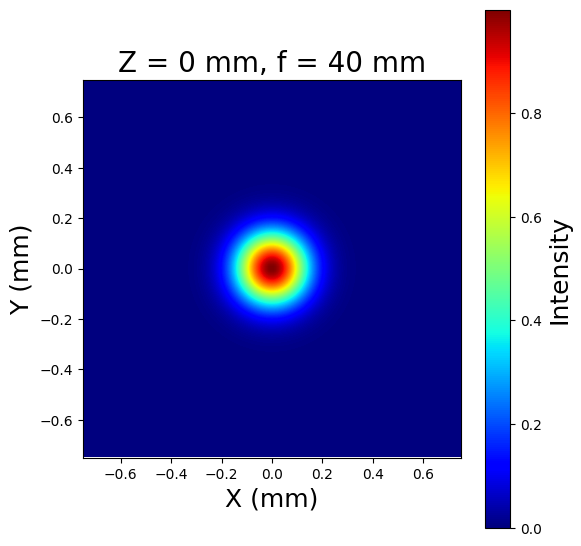

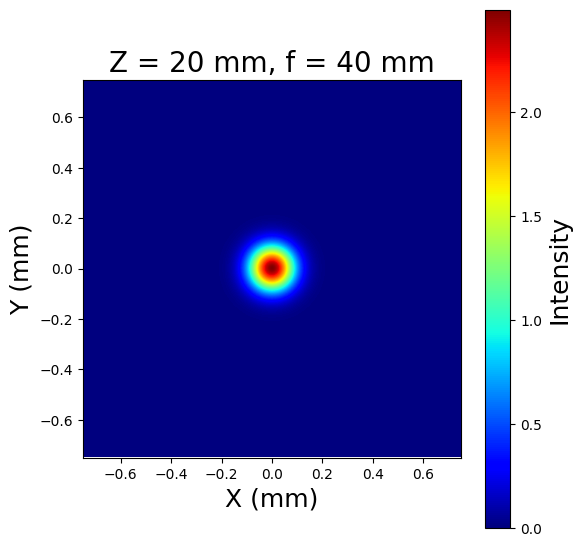

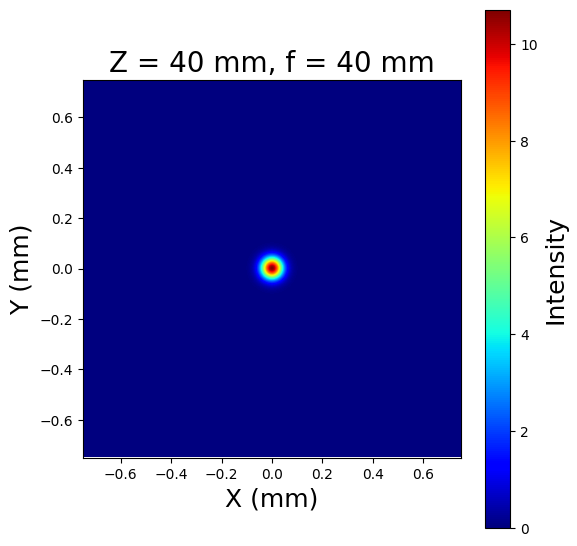

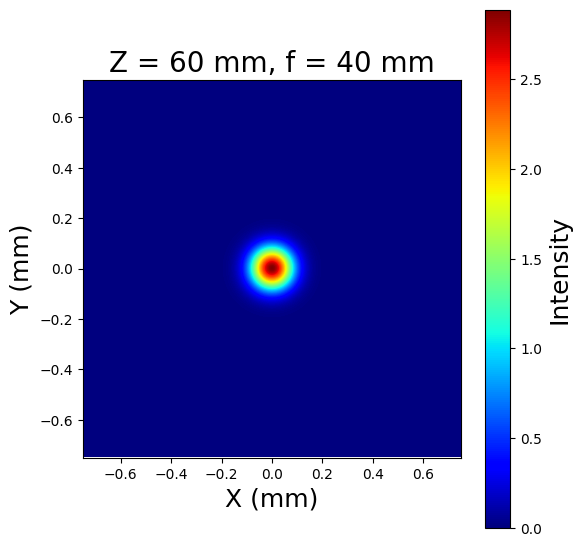

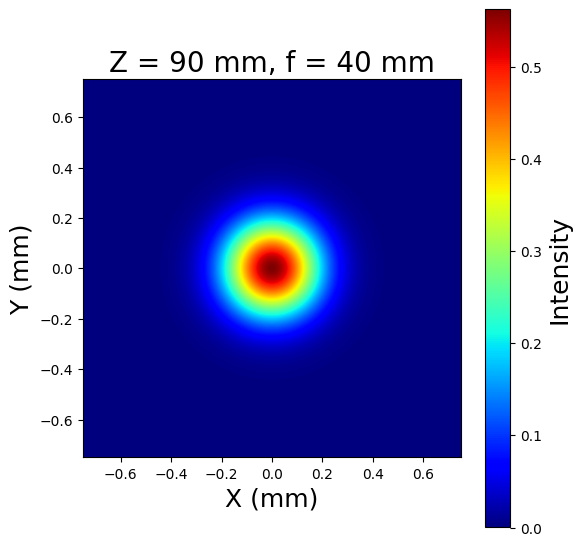

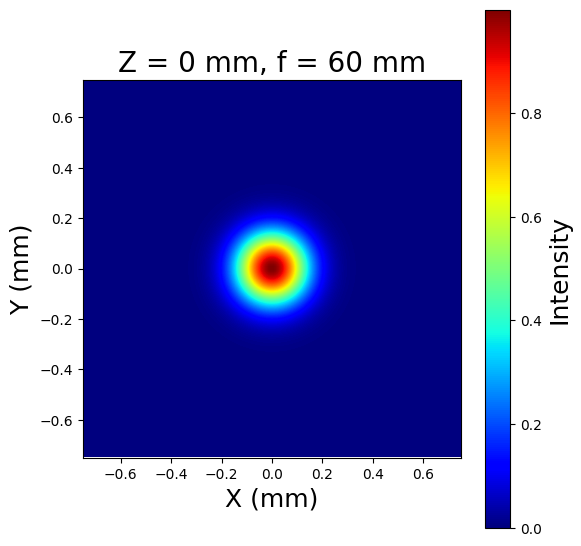

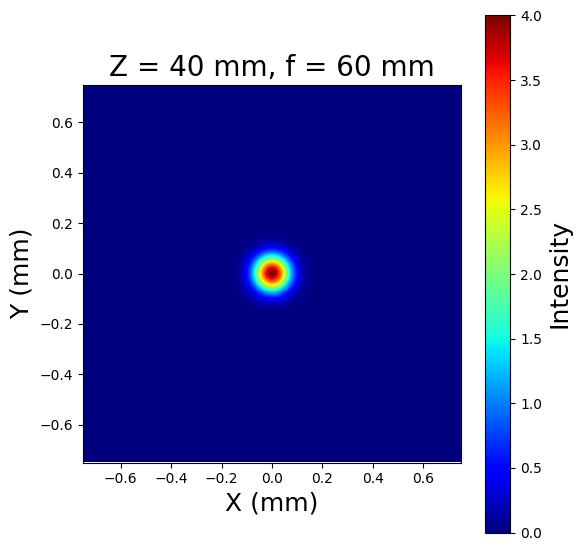

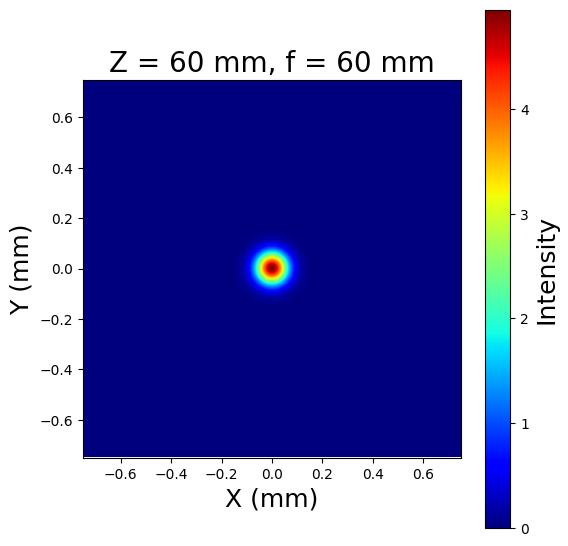

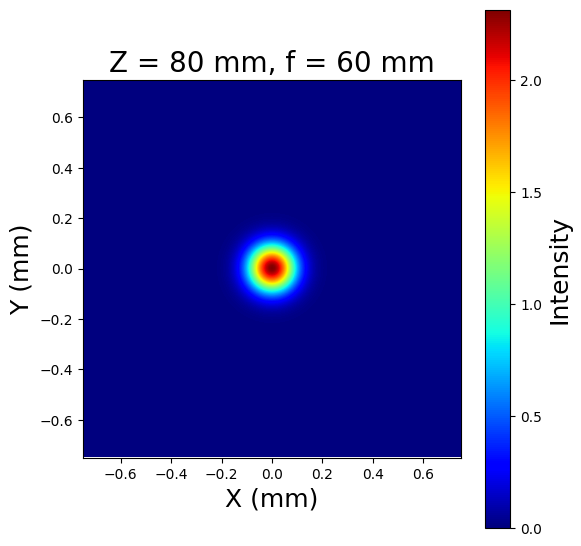

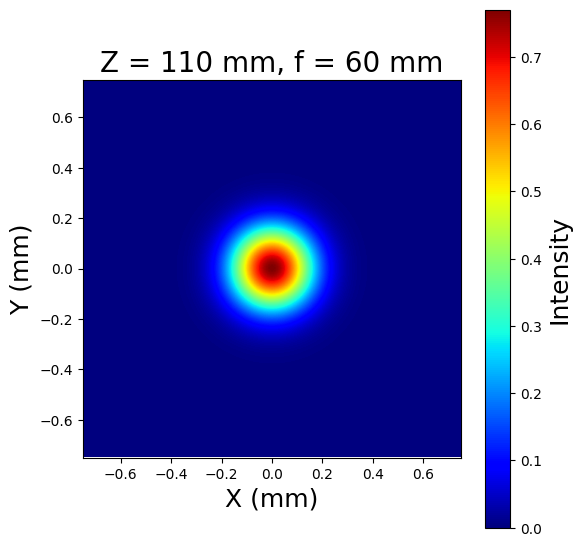

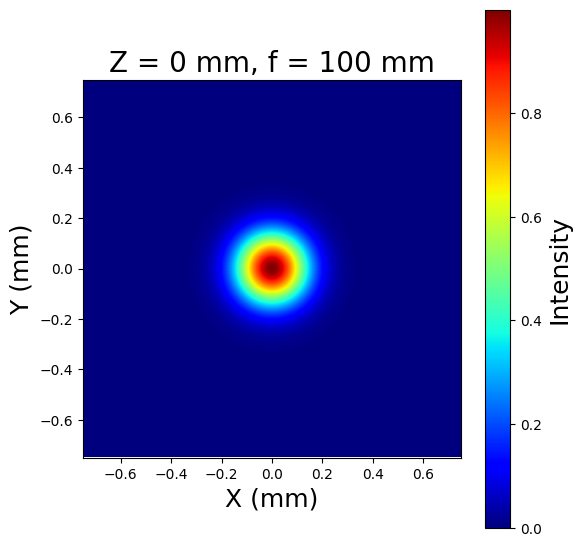

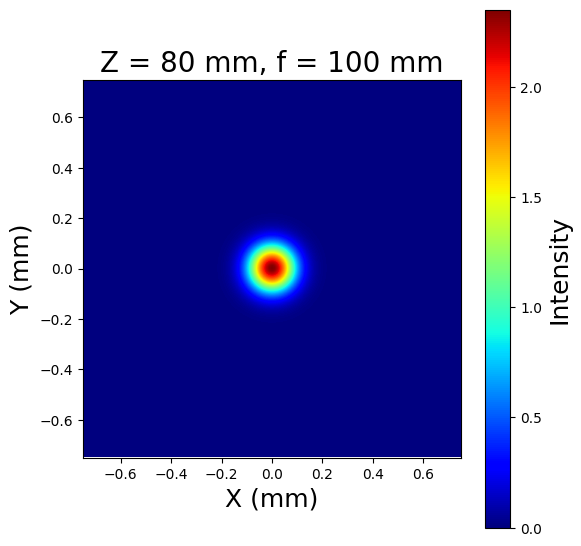

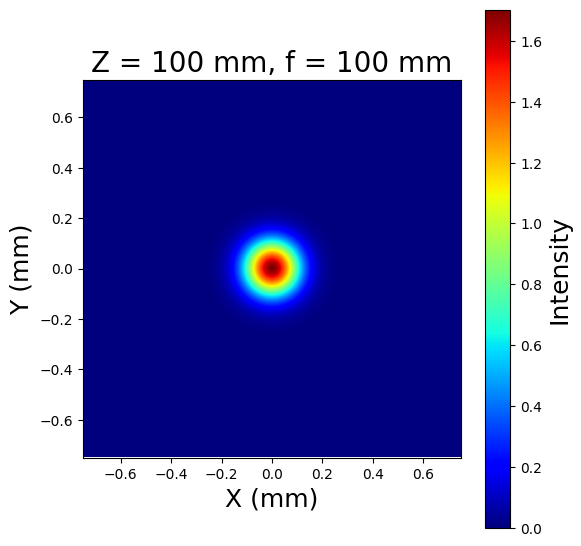

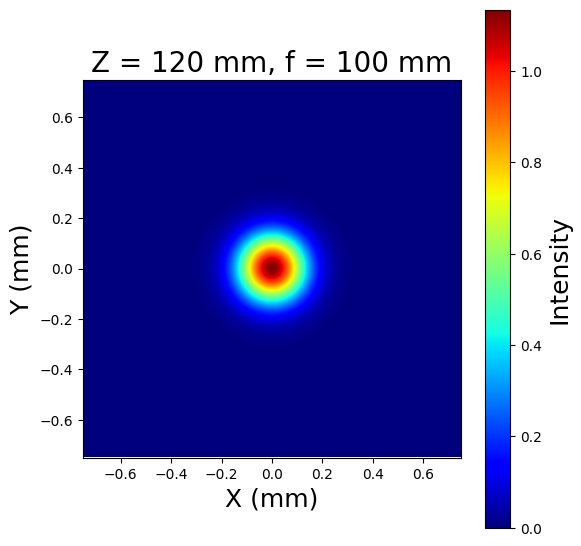

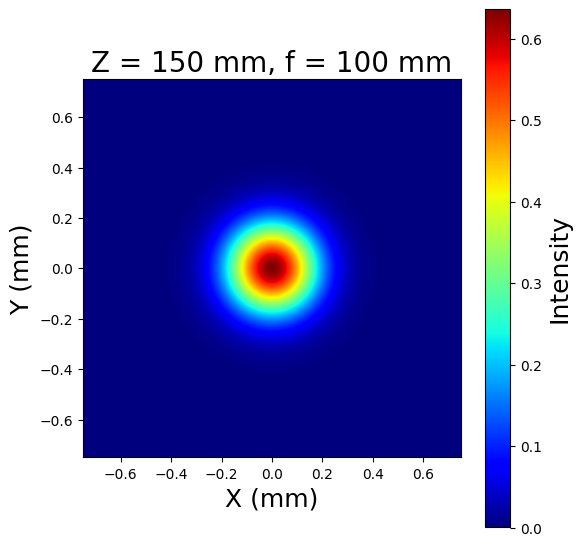

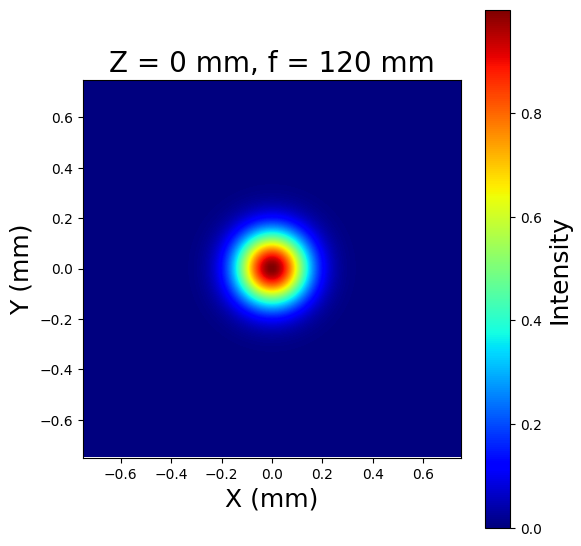

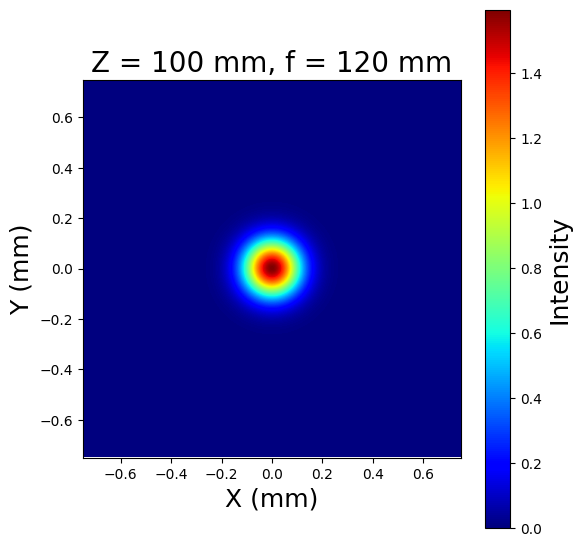

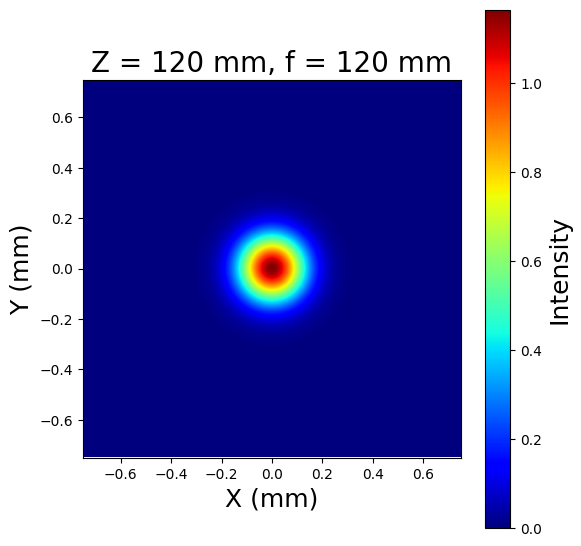

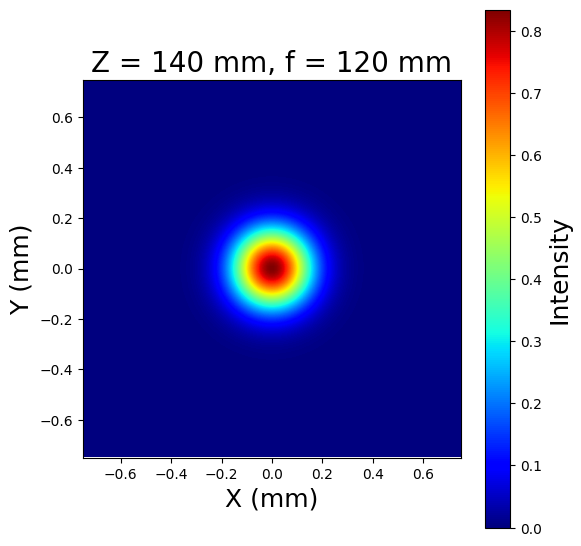

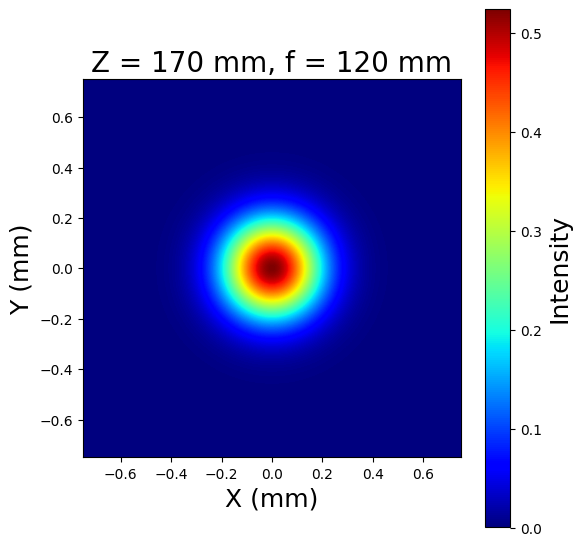

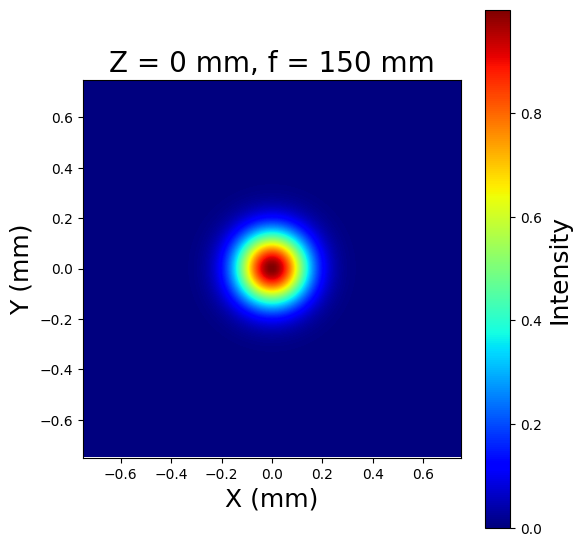

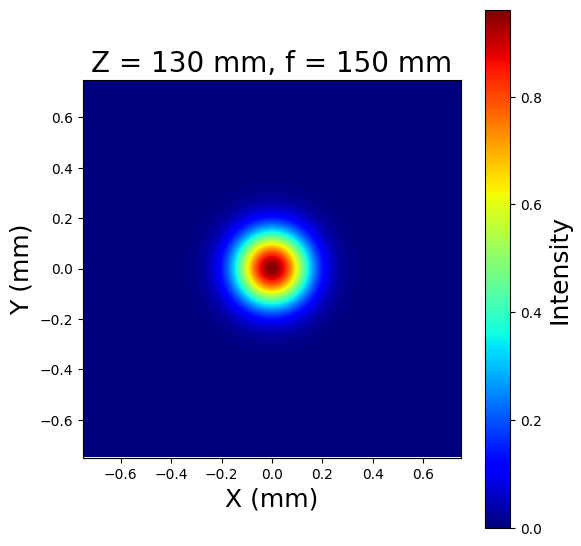

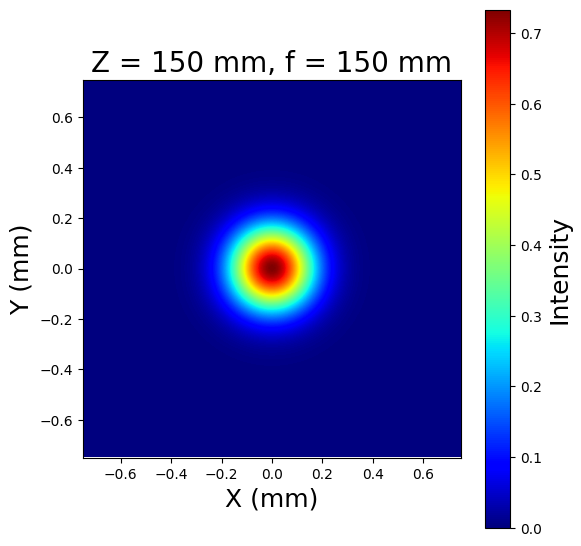

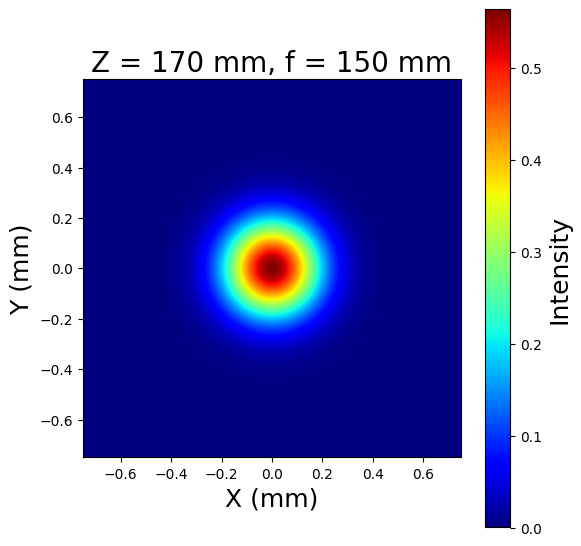

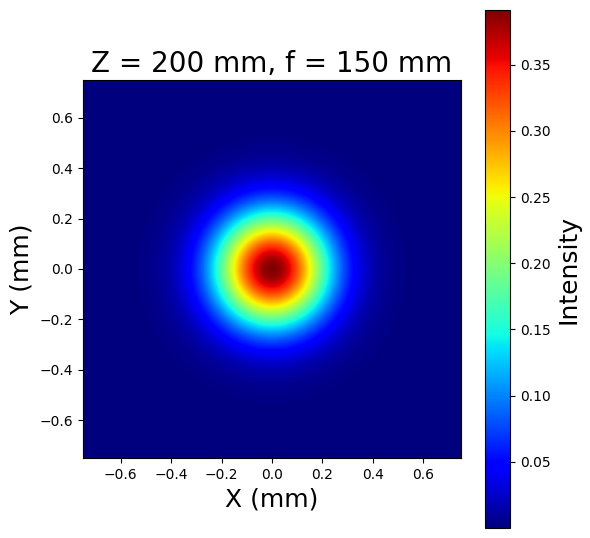

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Beam propagation using angular spectrum method
def angular_spectrum_method_with_padding(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    k = 2 * np.pi / wavelength
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)
    padded_field *= absorption_mask
    field_ft = np.fft.fft2(padded_field)
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))
    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)

    for count, z in enumerate(z_arr):
        phase_factor = np.exp(1j * kz * z)
        propagated_field_ft = field_ft * phase_factor
        propagated_field = np.fft.ifft2(propagated_field_ft)
        propagated_field = propagated_field[pad_width:-pad_width, pad_width:-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields

# Parameters
wavelength = 1e-3  # Wavelength in mm
Wo = 0.2  # Beam waist in mm
pad_width = 140  # Padding width
abs_coeff = 16  # Absorption coefficient
grid_size = 500
grid_extent = 1.5
dx = dy = grid_extent / grid_size
lens_position = 1
focal_lengths = [40, 60, 100, 120, 150]
x = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
y = np.linspace(-grid_extent / 2, grid_extent / 2, grid_size)
X, Y = np.meshgrid(x, y)
initial_field = np.exp(-(X**2 + Y**2) / Wo**2)
z_positions = np.linspace(0, 400, 200)

# Plotting for each focal length
for focal_length in focal_lengths:
    lens_phase = np.exp(((-1j * np.pi) / (wavelength * focal_length)) * (X**2 + Y**2))
    z_to_lens = np.linspace(0, lens_position, 2)
    field_to_lens = angular_spectrum_method_with_padding(initial_field, z_to_lens, wavelength, dx, dy, pad_width, abs_coeff)
    field_at_lens = field_to_lens[-1, :, :]
    field_after_lens = field_at_lens * lens_phase
    z_after_lens = np.linspace(lens_position, 400, len(z_positions) - 1)
    field_after_lens_all_z = angular_spectrum_method_with_padding(field_after_lens, z_after_lens, wavelength, dx, dy, pad_width, abs_coeff)
    propag_field = np.concatenate((field_to_lens, field_after_lens_all_z), axis=0)
    intensity = np.abs(propag_field)**2

    z_plot_positions = [0, focal_length - 20, focal_length, focal_length + 20, focal_length + 50]
    z_indices = [np.argmin(np.abs(z_after_lens - z)) for z in z_plot_positions]

    # Plot the intensity profile in the XY plane at the specified Z positions
    for i, z_idx in enumerate(z_indices):
        # Uncomment one of the following approaches

        # Approach 1: Adjust the layout with plt.subplots_adjust
        plt.figure(figsize=(7, 7))
        img = plt.imshow(intensity[z_idx, :, :], extent=[x[0], x[-1], y[0], y[-1]], aspect='equal', cmap='jet')
        cbar = plt.colorbar(img, label='Intensity')  # Create the colorbar with the label
        cbar.set_label('Intensity', fontsize=18)     # Set the label font size separately
        plt.xlabel('X (mm)', fontsize=18)
        plt.ylabel('Y (mm)', fontsize=18)
        plt.title(f'Z = {z_plot_positions[i]} mm, f = {focal_length} mm', fontsize=20)
        plt.subplots_adjust(top=0.85, right=0.8)  # Manually adjust layout
        plt.show()

        # Approach 2: Place colorbar below the plot
        #fig, ax = plt.subplots(figsize=(7, 7))
        #img = ax.imshow(intensity[z_idx, :, :], extent=[x[0], x[-1], y[0], y[-1]], aspect='equal', cmap='jet')
        #cbar = fig.colorbar(img, ax=ax, orientation='horizontal', pad=0.2)
       # cbar.set_label('Intensity')
        #ax.set_xlabel('X (mm)', fontsize=15)
        #ax.set_ylabel('Y (mm)', fontsize=15)
       # ax.set_title(f'XY Intensity Profile at \n Z = {z_plot_positions[i]} mm (Focal Length = {focal_length} mm)', fontsize=20)
       # plt.tight_layout()
        #plt.show()

        # Approach 3: Use constrained_layout to automatically adjust spacing
        # fig, ax = plt.subplots(figsize=(7, 10), constrained_layout=True)
        # img = ax.imshow(intensity[z_idx, :, :], extent=[x[0], x[-1], y[0], y[-1]], aspect='equal', cmap='jet')
        # cbar = fig.colorbar(img, ax=ax, label='Intensity')
        # ax.set_xlabel('X (mm)', fontsize=15)
        # ax.set_ylabel('Y (mm)', fontsize=15)
        # ax.set_title(f'XY Intensity Profile at Z = {z_plot_positions[i]} mm (Focal Length = {focal_length} mm)', fontsize=20)
        # plt.show()
